In [30]:
pip install matplotlib pandas numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


<h3>Importing Libraries<h3>

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

<h3>Loading the Dataset<h3>

In [32]:
train_data = os.path.join('Combined/Train')

test_data = os.path.join('Combined/Test')

In [33]:
activities = ['LAYING', 'SITTING', 'STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

In [34]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]
for activity in activities:
    folder = os.path.join(train_data,activity)
    data = os.listdir(folder)
   
    for csv in data:
        df=pd.read_csv(os.path.join(train_data,activity,csv),header=0)
        x_train.append(df.values[:500])
        y_train.append(activity)
for activity in activities:
    folder = os.path.join(test_data,activity)
    data = os.listdir(folder)
    
    for csv in data:
        df=pd.read_csv(os.path.join(test_data,activity,csv),header=0)
        x_test.append(df.values[:500])
        y_test.append(activity)
    

In [35]:
x_train=np.array(x_train)
y_train=np.array(y_train)
print(f"Shape of X_train = {x_train.shape}") 
print(f'Shape of y_train = {y_train.shape}')

x_test=np.array(x_test)
y_test=np.array(y_test)
print(f"Shape of X_test = {x_test.shape}")
print(f'Shape of y_test = {y_test.shape}')

Shape of X_train = (126, 500, 3)
Shape of y_train = (126,)
Shape of X_test = (54, 500, 3)
Shape of y_test = (54,)


<h3>Question 1 of Task 1<h3>

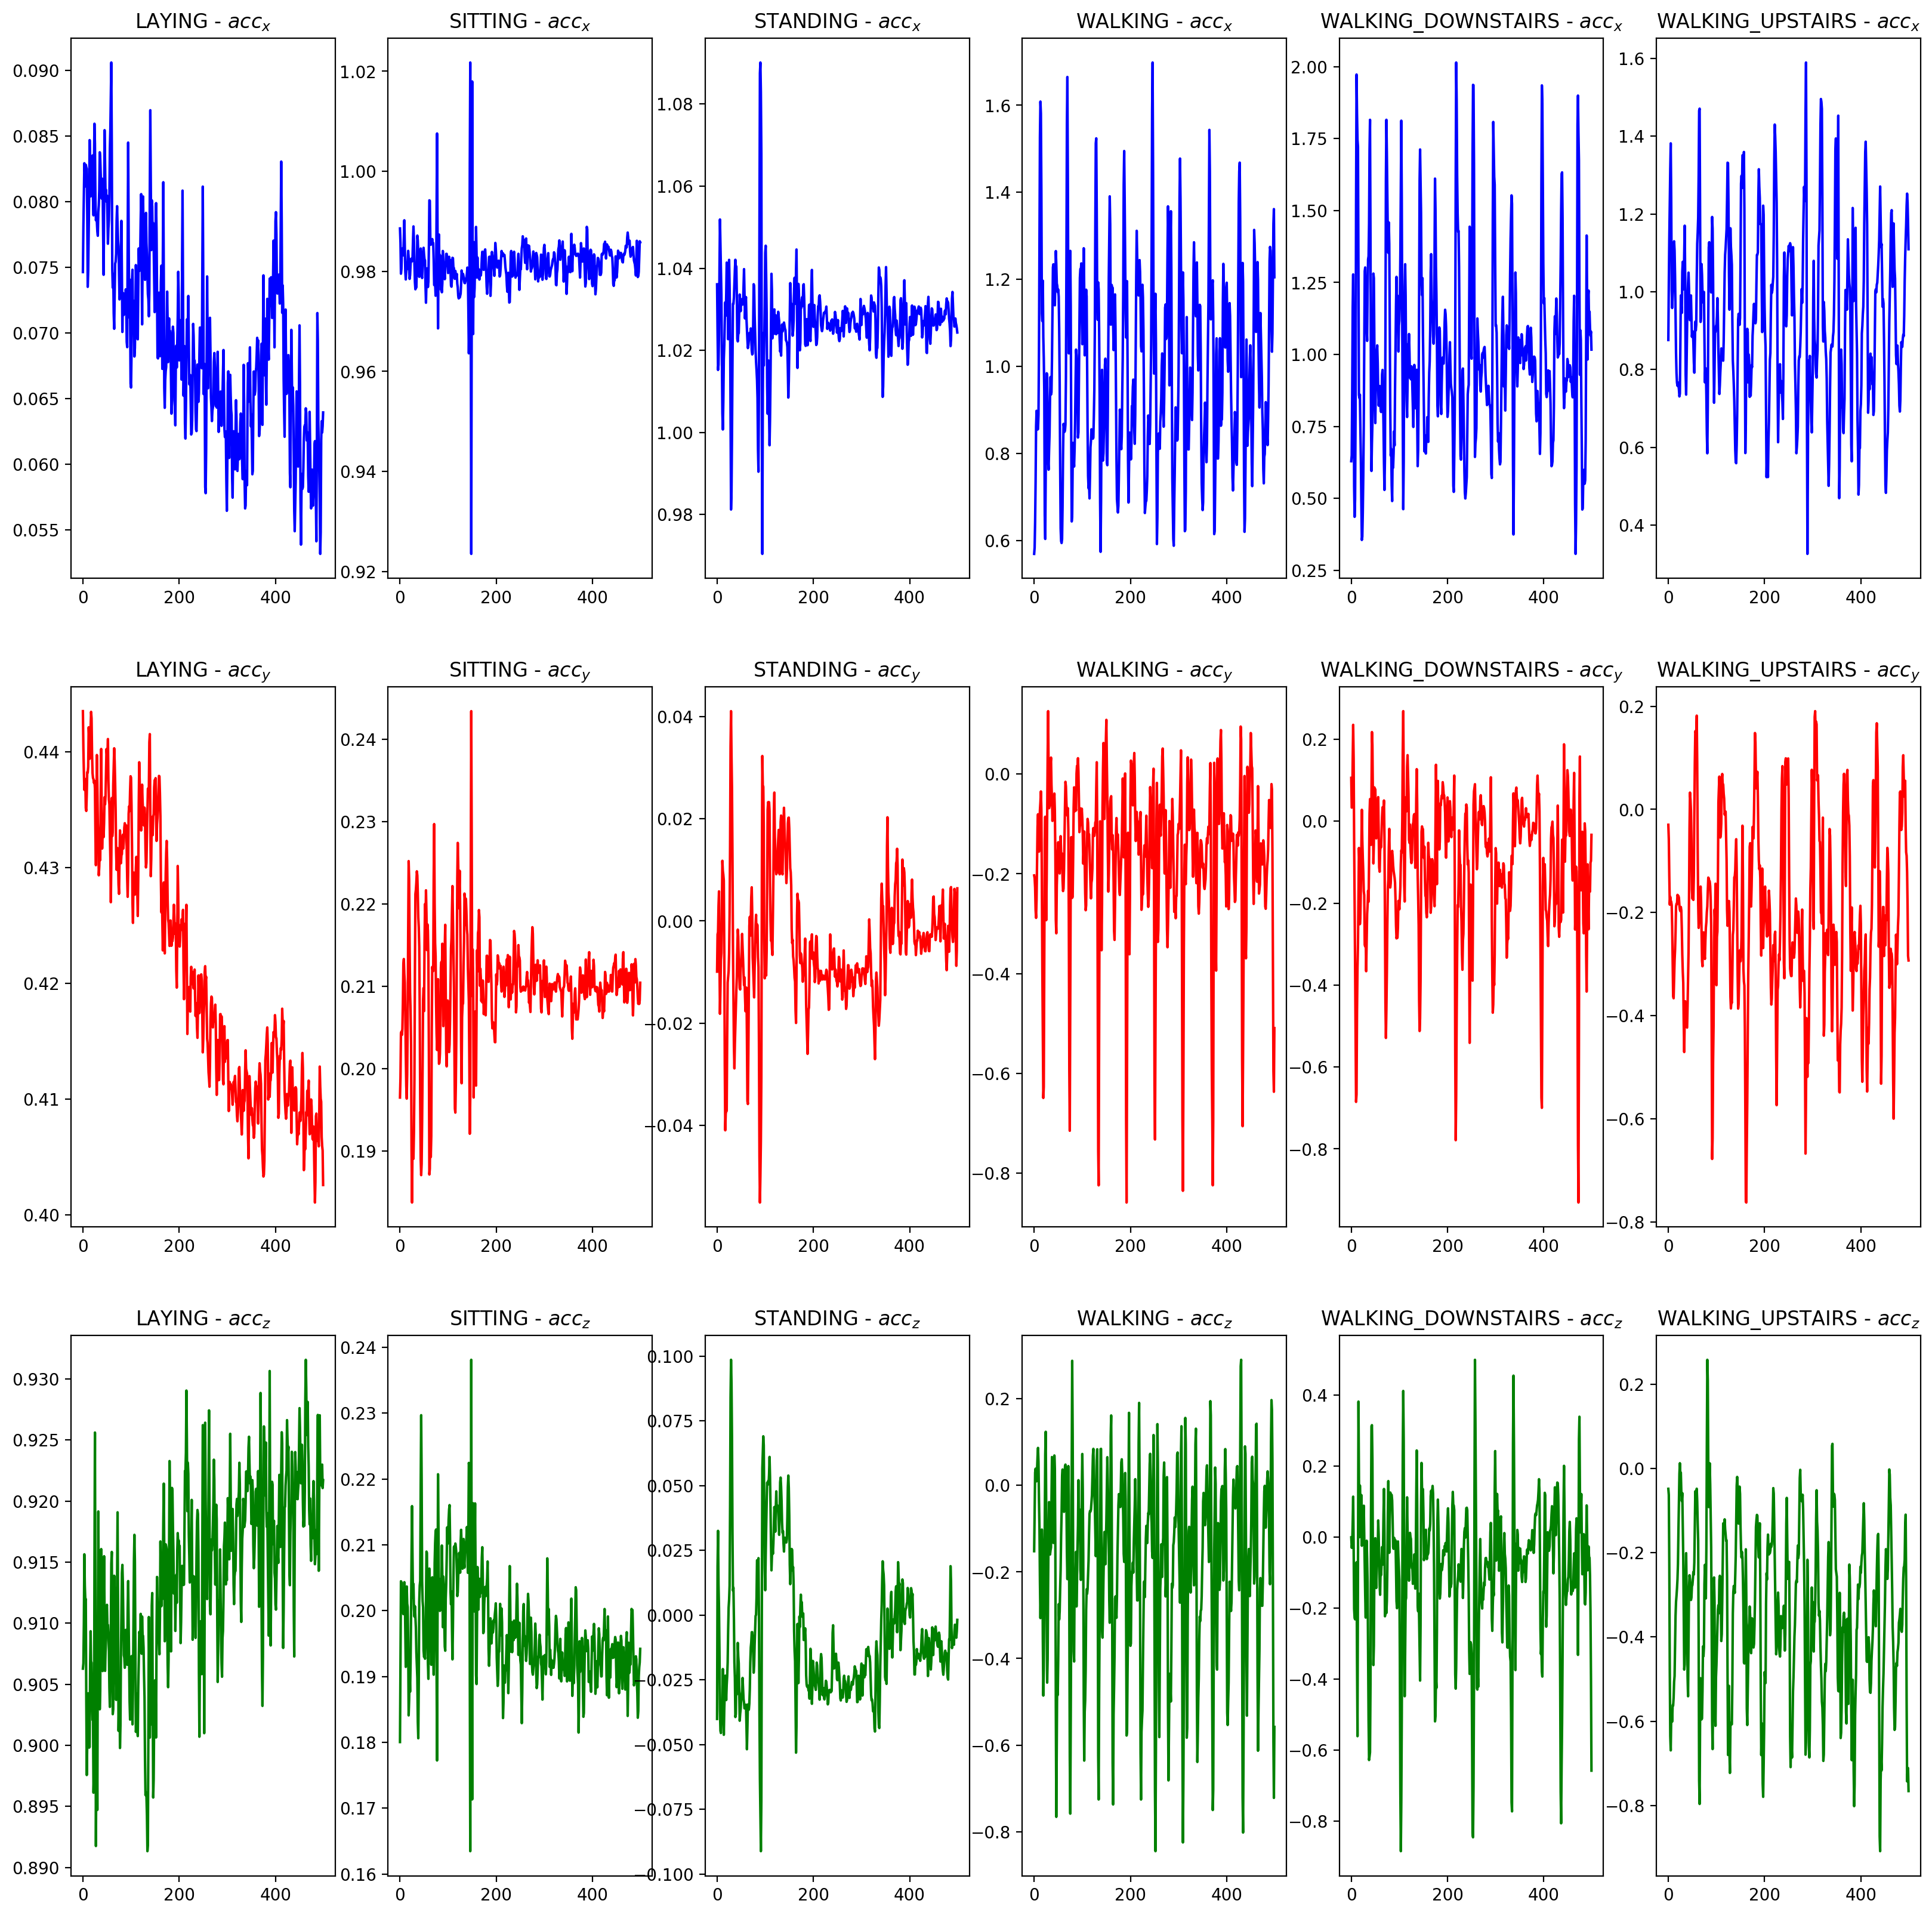

In [63]:
# Create large figure for subplots
plt.figure(figsize=(20,20))   

for i in range(6):            # Loop over 6 activities
    activity = activities[i]  # Activity label
    data = x_train[i*21]      # Pick one sample for this activity
    
    # Extract accelerometer signals (x, y, z)
    acc_x = data[:,0]
    acc_y = data[:,1]
    acc_z = data[:,2]
    
    x = np.arange(0,500,1)    # Time steps (0–499)
    
    # Plot x-axis signal
    plt.subplot(3,6,i+1)
    plt.plot(x, acc_x, c='b')
    plt.title(f"{activity} - $acc_x$")
    
    # Plot y-axis signal
    plt.subplot(3,6,i+7)
    plt.plot(x, acc_y, c='r')
    plt.title(f"{activity} - $acc_y$")
    
    # Plot z-axis signal
    plt.subplot(3,6,i+13)
    plt.plot(x, acc_z, c='g')
    plt.title(f"{activity} - $acc_z$")

plt.show()  


The differences/similarities between the various activities are:
1. The accelerometer values for static activities such as laying, sitting, and standing show much less variation compared to dynamic activities like walking, walking upstairs, and walking downstairs.
2. The readings for static activities differ significantly from each other (for example, acc_x values for laying are around 0.18–0.19, for sitting between 0.7–1.05, and for standing between 1.01–1.02), while dynamic activities have similar ranges (approximately 0.6–1.5).

Yes,the model should be able to clearly distinguish between static and dynamic activities, but it may encounter challenges when trying to differentiate between individual static or dynamic activities.

<h3>Question 2 of Task 1<h3>

In [37]:
# Compute total acceleration magnitude (x^2 + y^2 + z^2) 
total_acceleration = x_train[:,:,0]**2 + x_train[:,:,1]**2 + x_train[:,:,2]**2
total_acceleration_x_test = x_test[:,:,0]**2 + x_test[:,:,1]**2 + x_test[:,:,2]**2
for i in range(len(activities)):
    activity=activities[i]
    variance  = total_acceleration[i*21].var()
    Mean__ = total_acceleration[i*21].mean()
    print(f"Mean total acceleration for activity {activity} = {Mean__}")
    print(f"Variance in  total acceleration for activity {activity} = {variance}")

Mean total acceleration for activity LAYING = 1.0173545023409767
Variance in  total acceleration for activity LAYING = 0.00010205572045976707
Mean total acceleration for activity SITTING = 1.0465402278382336
Variance in  total acceleration for activity SITTING = 6.459791095313781e-05
Mean total acceleration for activity STANDING = 1.0556345681959554
Variance in  total acceleration for activity STANDING = 0.00037823382554365775
Mean total acceleration for activity WALKING = 1.1641451156369802
Variance in  total acceleration for activity WALKING = 0.28143999239115103
Mean total acceleration for activity WALKING_DOWNSTAIRS = 1.186554052652505
Variance in  total acceleration for activity WALKING_DOWNSTAIRS = 0.663661616765753
Mean total acceleration for activity WALKING_UPSTAIRS = 1.1614232314208484
Variance in  total acceleration for activity WALKING_UPSTAIRS = 0.2506061206082746


No, we do need machine learning model to separate static from dynamic activities. These groups can be classified using simple thresholds on properties like mean or variance, since these values differ significantly between static and dynamic activities.

<h3>Question 3 of Task 1<h3>

<h4>Perfoming PCA on Raw Data <h4>

In [38]:
from sklearn.decomposition import PCA

# Initialize PCA to reduce data to 2 principal components
pca = PCA(n_components=2, random_state=42)

# Fit PCA on the total_acceleration data
pca.fit(total_acceleration)

# Transform the data to the new 2D PCA space
pca_data = pca.transform(total_acceleration)

pca_data.shape  # Should be (126, 2) since we have 126 samples

(126, 2)

In [39]:
# Plot PCA-reduced data for each activity
for i in range(len(activities)):
    activity = activities[i]  
    # Select PCA data points for this activity (21 samples per activity)
    plt.scatter(pca_data[i*21:(i+1)*21, 0], pca_data[i*21:(i+1)*21, 1], label=activity)
    plt.legend()  # Show legend for activity labels

In [40]:
!pip install tsfel

<h4>Performing PCA on Features obtained using TSFEL<h4>

In [41]:
import tsfel    
import tsfel.feature_extraction.features

In [42]:
import tsfel
import pandas as pd
import numpy as np

def extract_features(data, sampling_rate=50):
   
    cfg = tsfel.get_features_by_domain()

    all_features = []
    for i in range(len(data)):
        signal = pd.Series(data[i])

        features = tsfel.time_series_features_extractor(cfg, signal, fs=sampling_rate)

        all_features.append(features.values.flatten())


    features_df = pd.DataFrame(all_features, columns=features.columns)
    return features_df


In [43]:
tsfel_features_train = extract_features(total_acceleration)
tsfel_features_test = extract_features(total_acceleration_x_test)

print("Training features shape:", tsfel_features_train.shape)
print("Testing features shape:", tsfel_features_test.shape)

Training features shape: (126, 156)
Testing features shape: (54, 156)


In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(tsfel_features_train)
tsfel_pca_data = pca.transform(tsfel_features_train)
tsfel_pca_data.shape

(126, 2)

In [45]:
for i in range(len(activities)):
    activity = activities[i]
    plt.scatter(tsfel_pca_data[i*21:(i+1)*21,0],tsfel_pca_data[i*21:(i+1)*21,1],label=activity)
    plt.legend()

<h3>PCA on features provided in dataset<h3>

In [46]:
X_train_features = np.loadtxt('UCI HAR Dataset/train/X_train.txt')
X_train_features.shape

(7352, 561)

In [47]:
y_train_features = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
y_train_features.shape

(7352,)

In [48]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X_train_features)
X_train_pca_data = pca.transform(X_train_features)
X_train_pca_data.shape

(7352, 2)

In [49]:
activities_map = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}

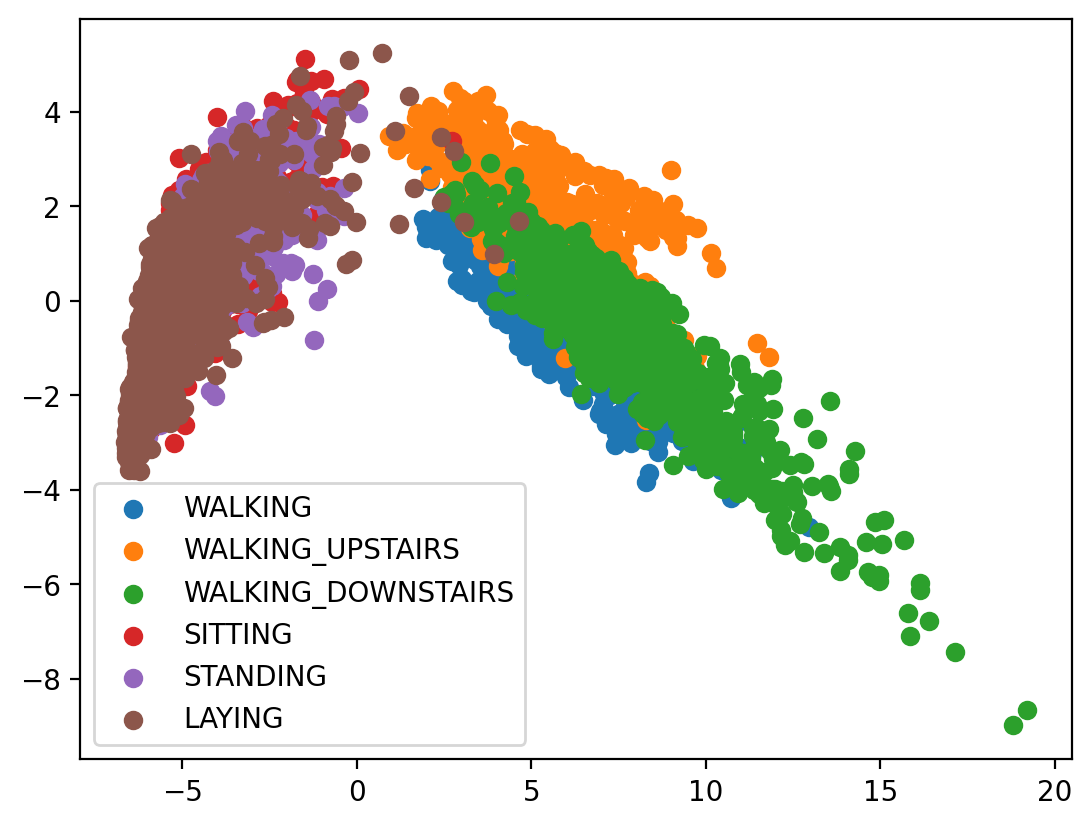

In [53]:
for i in range(1,7):
    plt.scatter(X_train_pca_data[y_train_features==i,0],X_train_pca_data[y_train_features==i,1],label=activities_map[i])
    plt.legend()
plt.show()

1. The PCA plot of total acceleration shows a lot of overlap between different activities, making it difficult to distinguish them.

2. In contrast, PCA applied to TSFEL features or the dataset’s provided features results in clearer separation, with activities forming distinct clusters and less overlap.

3. Both TSFEL features and the dataset’s original features are effective for visualizing and differentiating the activities.

<h3>Question 4 of Task 1 <h3>

In [54]:
features = np.loadtxt('UCI HAR Dataset/features.txt',dtype=str)
features = features[:, 1]

In [55]:
tsfel_features_train_df = pd.DataFrame(tsfel_features_train,columns=tsfel_features_train.columns)
dataset_features_train_df = pd.DataFrame(X_train_features,columns=features)

In [56]:
tsfel_features_train_df.columns = tsfel_features_train_df.columns.str.replace('^0_', '', regex=True)
print(tsfel_features_train_df.columns)

Index(['Absolute energy', 'Area under the curve', 'Autocorrelation',
       'Average power', 'Centroid', 'ECDF Percentile Count_0',
       'ECDF Percentile Count_1', 'ECDF Percentile_0', 'ECDF Percentile_1',
       'ECDF_0',
       ...
       'Wavelet variance_1.39Hz', 'Wavelet variance_1.56Hz',
       'Wavelet variance_1.79Hz', 'Wavelet variance_12.5Hz',
       'Wavelet variance_2.08Hz', 'Wavelet variance_2.5Hz',
       'Wavelet variance_3.12Hz', 'Wavelet variance_4.17Hz',
       'Wavelet variance_6.25Hz', 'Zero crossing rate'],
      dtype='object', length=156)


In [57]:
tsfel_features_train_df.corr()

,Absolute energy,Area under the curve,Autocorrelation,Average power,Centroid,ECDF Percentile Count_0,ECDF Percentile Count_1,ECDF Percentile_0,ECDF Percentile_1,ECDF_0,...,Wavelet variance_1.39Hz,Wavelet variance_1.56Hz,Wavelet variance_1.79Hz,Wavelet variance_12.5Hz,Wavelet variance_2.08Hz,Wavelet variance_2.5Hz,Wavelet variance_3.12Hz,Wavelet variance_4.17Hz,Wavelet variance_6.25Hz,Zero crossing rate
Absolute energy,1.000000,0.958144,-0.074475,1.000000,0.193766,NaN,NaN,-0.926880,0.961725,NaN,...,0.941081,0.969189,0.980580,0.929534,0.979763,0.974545,0.971304,0.966689,0.957283,NaN
Area under the curve,0.958144,1.000000,-0.091031,0.958144,0.157284,NaN,NaN,-0.928568,0.964871,NaN,...,0.883263,0.902638,0.906703,0.881627,0.899651,0.887853,0.875166,0.862845,0.868481,NaN
Autocorrelation,-0.074475,-0.091031,1.000000,-0.074475,-0.030978,NaN,NaN,0.057230,-0.068681,NaN,...,-0.060595,-0.060720,-0.060064,-0.075360,-0.059174,-0.058641,-0.058747,-0.060505,-0.068533,NaN
Average power,1.000000,0.958144,-0.074475,1.000000,0.193766,NaN,NaN,-0.926880,0.961725,NaN,...,0.941081,0.969189,0.980580,0.929534,0.979763,0.974545,0.971304,0.966689,0.957283,NaN
Centroid,0.193766,0.157284,-0.030978,0.193766,1.000000,NaN,NaN,-0.170841,0.206578,NaN,...,0.243126,0.254164,0.249636,0.082323,0.235012,0.219700,0.212616,0.202888,0.152745,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wavelet variance_2.5Hz,0.974545,0.887853,-0.058641,0.974545,0.219700,NaN,NaN,-0.879711,0.928454,NaN,...,0.902949,0.951702,0.982156,0.881021,0.996644,1.000000,0.996640,0.980196,0.936339,NaN
Wavelet variance_3.12Hz,0.971304,0.875166,-0.058747,0.971304,0.212616,NaN,NaN,-0.860440,0.912485,NaN,...,0.893777,0.941949,0.972933,0.891207,0.989365,0.996640,1.000000,0.991984,0.953192,NaN
Wavelet variance_4.17Hz,0.966689,0.862845,-0.060505,0.966689,0.202888,NaN,NaN,-0.840875,0.888402,NaN,...,0.895366,0.935711,0.959972,0.910608,0.972197,0.980196,0.991984,1.000000,0.979065,NaN
Wavelet variance_6.25Hz,0.957283,0.868481,-0.068533,0.957283,0.152745,NaN,NaN,-0.840667,0.865245,NaN,...,0.889960,0.916458,0.928409,0.956599,0.931590,0.936339,0.953192,0.979065,1.000000,NaN


In [58]:
dataset_features_train_df.corr()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
tBodyAcc-mean()-X,1.000000,0.148061,-0.256952,0.000619,-0.021903,-0.044617,0.006290,-0.022754,-0.047558,0.044062,...,0.030681,-0.017557,-0.015613,-0.544320,0.012173,0.037444,0.028844,-0.035257,0.034371,0.028242
tBodyAcc-mean()-Y,0.148061,1.000000,-0.078769,-0.045160,-0.044920,-0.049746,-0.044180,-0.045049,-0.050402,-0.038108,...,-0.022395,-0.001587,-0.004459,0.070559,-0.013541,0.017967,0.075679,-0.005309,0.001053,-0.013903
tBodyAcc-mean()-Z,-0.256952,-0.078769,1.000000,-0.020217,-0.016641,-0.008410,-0.018747,-0.015203,-0.001988,-0.037197,...,-0.020481,0.020091,0.019127,0.052841,-0.039836,-0.063609,-0.034037,0.008587,-0.015288,-0.022643
tBodyAcc-std()-X,0.000619,-0.045160,-0.020217,1.000000,0.927461,0.851668,0.998632,0.920888,0.846392,0.980844,...,-0.065987,0.148034,0.115565,-0.035011,-0.021633,0.018985,-0.024810,-0.371653,0.471065,0.394825
tBodyAcc-std()-Y,-0.021903,-0.044920,-0.016641,0.927461,1.000000,0.895510,0.922803,0.997347,0.894509,0.917366,...,-0.105621,0.206227,0.176946,-0.020379,-0.012505,-0.008507,-0.014592,-0.380531,0.523600,0.433169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",0.037444,0.017967,-0.063609,0.018985,-0.008507,-0.018429,0.019389,-0.012546,-0.023525,0.025066,...,-0.026615,0.034514,0.024553,-0.006269,0.009141,1.000000,-0.116001,-0.005853,-0.012313,-0.019903
"angle(tBodyGyroJerkMean,gravityMean)",0.028844,0.075679,-0.034037,-0.024810,-0.014592,-0.006471,-0.024951,-0.012341,-0.007231,-0.028871,...,0.000102,-0.017937,-0.014865,-0.020823,0.035263,-0.116001,1.000000,0.023995,-0.005869,-0.005656
"angle(X,gravityMean)",-0.035257,-0.005309,0.008587,-0.371653,-0.380531,-0.345011,-0.368191,-0.377025,-0.347389,-0.384192,...,0.087332,-0.086006,-0.079751,0.011880,0.023246,-0.005853,0.023995,1.000000,-0.783848,-0.643655
"angle(Y,gravityMean)",0.034371,0.001053,-0.015288,0.471065,0.523600,0.476006,0.466424,0.525081,0.477607,0.480229,...,-0.100125,0.086993,0.078079,0.001540,-0.012990,-0.012313,-0.005869,-0.783848,1.000000,0.594885


In [62]:
import numpy as np

threshold = 0.95

# Compute correlation matrix for TSFEL features
corr_matrix_tsfel = tsfel_features_train_df.corr()

# Select upper triangle of correlation matrix to avoid duplicate pairs
upper_tsfel = corr_matrix_tsfel.where(np.triu(np.ones(corr_matrix_tsfel.shape), k=1).astype(bool))

# Find features with correlation higher than threshold
high_corr_tsfel = [column for column in upper_tsfel.columns if any(upper_tsfel[column].abs() > threshold)]

print("Highly correlated TSFEL features (possible redundancy):")
print(high_corr_tsfel)


Highly correlated TSFEL features (possible redundancy):
['Area under the curve', 'Average power', 'ECDF Percentile_1', 'Human range energy', 'Interquartile range', 'LPCC_0', 'LPCC_10', 'LPCC_11', 'LPCC_2', 'LPCC_4', 'LPCC_5', 'LPCC_6', 'LPCC_7', 'LPCC_8', 'LPCC_9', 'MFCC_0', 'Max', 'Mean', 'Mean absolute deviation', 'Mean absolute diff', 'Median absolute deviation', 'Median absolute diff', 'Median frequency', 'Min', 'Peak to peak distance', 'Positive turning points', 'Root mean square', 'Signal distance', 'Spectral centroid', 'Spectral distance', 'Spectral entropy', 'Spectral kurtosis', 'Spectral roll-off', 'Spectral skewness', 'Spectral slope', 'Spectral spread', 'Spectrogram mean coefficient_1.61Hz', 'Standard deviation', 'Sum absolute diff', 'Variance', 'Wavelet absolute mean_1.56Hz', 'Wavelet absolute mean_1.79Hz', 'Wavelet absolute mean_2.08Hz', 'Wavelet absolute mean_2.5Hz', 'Wavelet absolute mean_3.12Hz', 'Wavelet absolute mean_4.17Hz', 'Wavelet absolute mean_6.25Hz', 'Wavelet e

In [60]:
# For original dataset features
corr_matrix_dataset = dataset_features_train_df.corr()
upper_dataset = corr_matrix_dataset.where(np.triu(np.ones(corr_matrix_dataset.shape), k=1).astype(bool))
high_corr_dataset = [column for column in upper_dataset.columns if any(upper_dataset[column].abs() > threshold)]

print("\nHighly correlated dataset features (possible redundancy):")
print(high_corr_dataset)



Highly correlated dataset features (possible redundancy):
['tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tGravityAcc-mad()-X', 'tGravityAcc-mad()-Y', 'tGravityAcc-mad()-Z', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-max()-Z', 'tGravityAcc-min()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-min()-Z', 'tGravityAcc-energy()-X', 'tGravityAcc-iqr()-X', 'tGravityAcc-iqr()-Y', 'tGravityAcc-iqr()-Z', 'tGravityAcc-arCoeff()-X,2', 'tGravityAcc-arCoeff()-X,3', 'tGravityAcc-arCoeff()-X,4', 'tGravityAcc-arCoeff()-Y,2', 'tGravityAcc-arCoeff()-Y,3', 'tGravityAcc-arCoeff()-Y,4', 'tGravityAcc-arCoeff()-Z,2', 'tGravityAcc-arCoeff()-Z,3', 'tGravityAcc-arCoeff()-Z,4', 'tBodyAccJerk-std()-X', 'tBodyAccJerk-std()-Y', 'tBodyAccJerk-mad()-X', 'tBodyAccJerk-mad()-Y', 'tBodyAccJerk-mad()-Z', 'tBodyAccJerk-ma